In [7]:
# enable autoreload
%load_ext autoreload
%autoreload 2

import sys, os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from monai.losses import DiceCELoss

# include project src in path
sys.path.append(os.path.abspath("src"))
from inference import run_inference, evaluate
from monai.losses import DiceCELoss
from utils_visualization import visualize_slices


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# set parameters
DATA_DIR       = "/datasets/tdt4265/mic/open/HNTS-MRG"
CHECKPOINT     = "results/exp22_nnunet/checkpoints/best.ckpt"
OUTPUT_DIR     = "results/inference"
BATCH_SIZE     = 3
MODEL_TYPE     = "nnunet"
DEVICE         = torch.device("cuda:0")      

# run inference and grab model + loader
model, test_loader = run_inference(
    data_dir   = DATA_DIR,
    checkpoint = CHECKPOINT,
    output_dir = OUTPUT_DIR,
    batch_size = BATCH_SIZE,
    model_type = MODEL_TYPE,
    device     = DEVICE,
    save_labels= True,
)

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Loading dataset: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


Inference done; outputs in results/inference


In [14]:
loss_fn = DiceCELoss(
    to_onehot_y=True, softmax=True,
    weight=torch.tensor([0.4,1.7,1.5]).to(DEVICE),
    lambda_dice=0.7, lambda_ce=0.3
)

# evaluate the model on the test set
metrics = evaluate(
    model=model,
    dataloader=test_loader,
    loss_criterion=loss_fn, 
    device=DEVICE
)

# print the metrics
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")



avg_loss: 0.4424
mean_dice: 0.5265
dice_class1: 0.4735
dice_class2: 0.5795
prec_class1: 0.6295
recall_class1: 0.6316
prec_class2: 0.6696
recall_class2: 0.6356


Label class distribution: (1738493, 22930, 8049)
Prediction class distribution: (1741360, 20611, 7501)


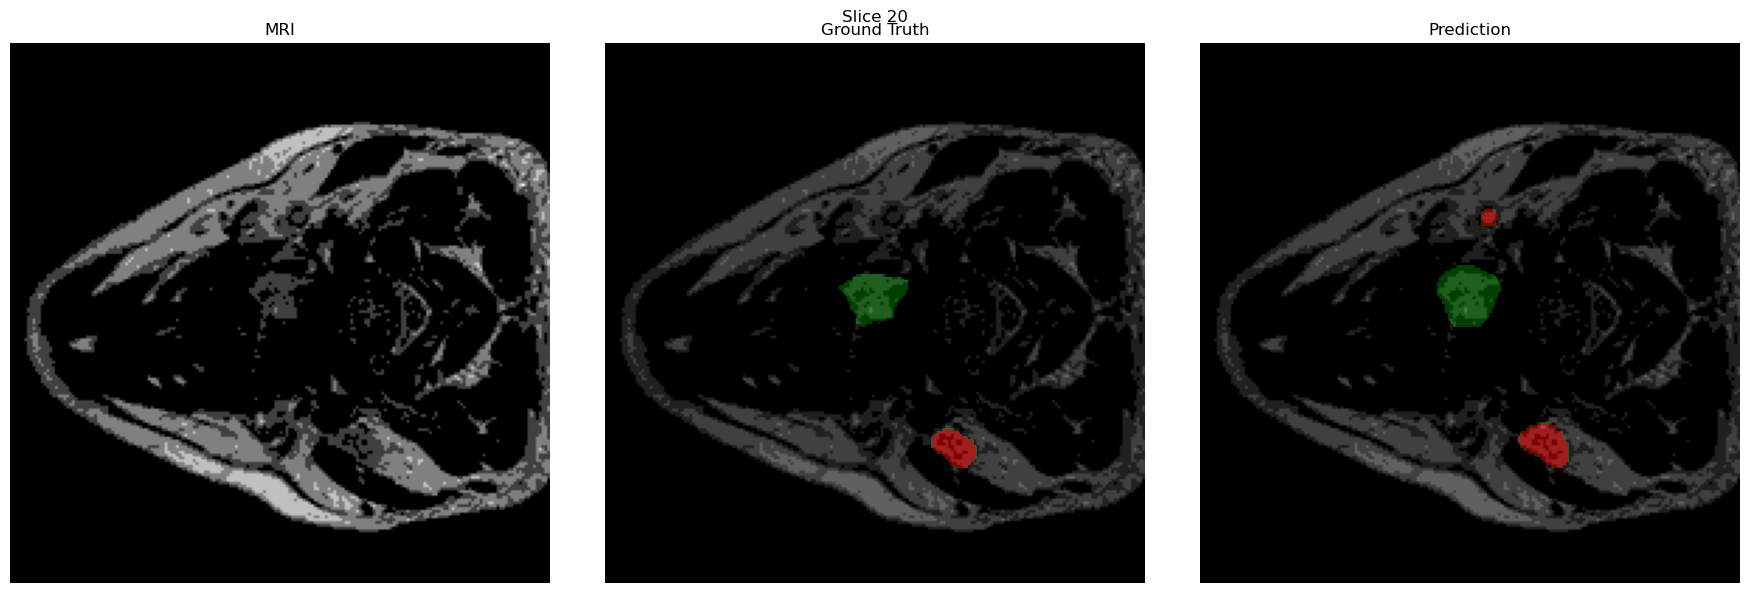

In [11]:
### VISUALIZE SLICES ###
visualize_slices(
    image_path     = f"{OUTPUT_DIR}/image_3.nii.gz",
    label_path     = f"{OUTPUT_DIR}/label_3.nii.gz",
    prediction_path= f"{OUTPUT_DIR}/prediction_3.nii.gz",
    slice_idx      = 20
)
